In [1]:
import torch.nn as nn
import torch
import rawpy
import numpy as np
from torch.utils.data import DataLoader
from utils.datasets import LabeledDataset
from utils.preprocess import adjust_black_level

import torchvision.transforms as transforms

import ignite.distributed as idist
from ignite.engine import Engine, Events
from ignite.contrib.handlers import ProgressBar
from ignite.metrics import FID, InceptionScore, RunningAverage

from torch.profiler import profile, record_function, ProfilerActivity

from torchinfo import summary

torch.manual_seed(9706507364633013713)

In [2]:
root_dir = "dataset"
sony_csv_files = ["dataset/Sony_train_list.txt"]
fuji_csv_files =  ["dataset/Fuji_train_list.txt"]

batch_size = 8
input_size = 512

pre_crop_transform = transforms.Compose([
    transforms.ToTensor()
])

sony_dataset = LabeledDataset(root_dir, *sony_csv_files, training=True, transform=pre_crop_transform)
sony_dataloader = idist.auto_dataloader(sony_dataset, batch_size=batch_size, num_workers=32, shuffle=True, drop_last=True, prefetch_factor=1)
print(sony_dataset[0][0].shape)
print(sony_dataset[0][1].shape)

2023-06-13 02:52:29,723 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<utils.datasets.Labe': 
	{'batch_size': 8, 'num_workers': 32, 'shuffle': True, 'drop_last': True, 'prefetch_factor': 1, 'pin_memory': True}


torch.Size([4, 512, 512])
torch.Size([3, 1024, 1024])


In [3]:
sony_dataset.prime_buffer()

In [4]:
# from unet.unet_model import UNet
from torch import optim 
from ignite.handlers.param_scheduler import LRScheduler

class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(ConvBlock, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channel, out_channel, 3, padding=1)
        self.lrelu1_1 = nn.LeakyReLU(0.2, inplace=True)
        self.conv1_2 = nn.Conv2d(out_channel, out_channel, 3, padding=1)
        self.lrelu1_2 = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        x = self.conv1_1(x)
        x = self.lrelu1_1(x)
        x = self.conv1_2(x)
        x = self.lrelu1_2(x)
        return x
    
class UpConcatBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(UpConcatBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channel, in_channel // 2, kernel_size=2, stride=2)
        self.conv_block = ConvBlock(in_channel, out_channel)

    def forward(self, x1, x2):
        x1 = self.deconv(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = torch.nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv_block(x)

class UNet(nn.Module):
    def __init__(self, in_feat):
        super(UNet, self).__init__()
        
        self.down1 = ConvBlock(in_feat, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = ConvBlock(32, 64)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = ConvBlock(64, 128)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = ConvBlock(128, 256)
        self.pool4 = nn.MaxPool2d(2)
        self.down5 = ConvBlock(256, 512)
        self.pool5 = nn.MaxPool2d(2)
        self.down6 = ConvBlock(512, 1024)
        self.pool6 = nn.MaxPool2d(2)
        self.down7 = ConvBlock(1024, 2048)
        self.pool7 = nn.MaxPool2d(2)
        self.down8 = ConvBlock(2048, 4096)

        self.up8 = UpConcatBlock(4096, 2048)
        self.up7 = UpConcatBlock(2048, 1024)
        self.up6 = UpConcatBlock(1024, 512)
        self.up5 = UpConcatBlock(512, 256)
        self.up4 = UpConcatBlock(256, 128)
        self.up3 = UpConcatBlock(128, 64)
        self.up2 = UpConcatBlock(64, 32)

        self.conv10 = nn.Conv2d(32, 12, 1)

    def forward(self, x):
        down1 = self.down1(x)
        down2 = self.down2(self.pool1(down1))
        down3 = self.down3(self.pool2(down2))
        down4 = self.down4(self.pool3(down3))
        down5 = self.down5(self.pool4(down4))
        down6 = self.down6(self.pool5(down5))
        down7 = self.down7(self.pool6(down6))
        down8 = self.down8(self.pool7(down7))

        up = self.up8(down8, down7)
        up = self.up7(up, down6)
        up = self.up6(up, down5)
        up = self.up5(up, down4)
        up = self.up4(up, down3)
        up = self.up3(up, down2)
        up = self.up2(up, down1)

        out = self.conv10(up)
        out = torch.nn.functional.pixel_shuffle(out, 2)
        return out

net = UNet(4)
model = idist.auto_model(net)
optimizer = idist.auto_optim(optim.Adam(model.parameters(), lr=1e-4))
loss = nn.L1Loss()
lr_scheduler = LRScheduler(optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8))

In [5]:
# input_data = torch.randn(batch_size, 4, input_size, input_size)
# summary(model, input_data = input_data)

In [6]:
def random_crop(image_short, image_long, size):
    H = image_short.shape[2]
    W = image_short.shape[3]
    ps = size
    xx = np.random.randint(0, W - ps)
    yy = np.random.randint(0, H - ps)
    image_short = image_short[:,:,yy:yy + ps, xx:xx + ps]
    image_long = image_long[:,:,yy * 2:yy * 2 + ps * 2, xx * 2:xx * 2 + ps * 2]
    return image_short, image_long

def pack_sony_raw(batch, device=None):
    if not device:
        device = idist.device()
    batch = torch.maximum(batch - 512, torch.Tensor([0]).to(device=device)) / (16383 - 512)
    H = batch.shape[2]
    W = batch.shape[3]

    out = torch.cat((batch[:,:, 0:H:2, 0:W:2], 
                     batch[:,:, 0:H:2, 1:W:2],
                     batch[:,:, 1:H:2, 1:W:2],
                     batch[:,:, 1:H:2, 0:W:2]), dim=1)
    return out

In [7]:
def training_step(engine, batch):
    model.train()
    optimizer.zero_grad()

    short, long, ratio, cam_model, exposure_ratio, _, _ = batch

    short = short.to(idist.device())
    long = long.to(idist.device())

    # short = pack_sony_raw(short)

    long = long / 65535.0
    short = adjust_black_level(short, device=idist.device())
    short = short * exposure_ratio.float().to(idist.device()).view(-1, 1, 1, 1)
    # short, long = random_crop(short, long, input_size)

    output = model(short)

    g_loss = loss(output, long)
        
    g_loss.backward()
    optimizer.step()
    return {"Loss_G": g_loss.item()}

In [8]:
trainer = Engine(training_step)
trainer.add_event_handler(Events.EPOCH_STARTED, lr_scheduler)
RunningAverage(output_transform=lambda x: x["Loss_G"]).attach(trainer, 'Loss_G')
ProgressBar().attach(trainer, metric_names=['Loss_G'])

G_losses = []

@trainer.on(Events.EPOCH_COMPLETED)
def store_losses(engine):
    o = engine.state.output
    print(o["Loss_G"])
    G_losses.append(o["Loss_G"])

best_l1 = 9999
@trainer.on(Events.EPOCH_COMPLETED)
def save_checkpoint(engine):
    global best_l1
    if engine.state.output["Loss_G"] < best_l1:
        best_l1 = engine.state.output["Loss_G"]
        print('New Best Score')
        torch.save({
            'epoch': engine.state.epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'model_best.pt')

/kubernetes/temp/project/ece285_project_deep/.venv/lib/python3.10/site-packages/ignite/contrib/handlers/tqdm_logger.py:127: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [9]:
# torch.save({
#             'epoch': num_epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': loss,
#             }, 'model_seed_{}.pt'.format(torch.random.initial_seed()))

# Load model parameters from checkpoint
epochs_ran = torch.load('model_best.pt')['epoch']
model.load_state_dict(torch.load('model_best.pt')['model_state_dict'])
optimizer.load_state_dict(torch.load('model_best.pt')['optimizer_state_dict'])
loss = torch.load('model_best.pt')['loss']


In [10]:
total_epochs_to_run = 100

num_epoch = total_epochs_to_run - epochs_ran

def training(*args):
    # with profile(activities=[ProfilerActivity.CPU], record_shapes=True, profile_memory=True, with_stack=True) as prof:
    trainer.run(sony_dataloader, max_epochs=num_epoch)

    # print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=100))
    # print(prof.key_averages().table(sort_by="cpu_memory_usage", row_limit=100))
    # prof.export_chrome_trace("trace.json")
    # https://github.com/pytorch/pytorch/issues/100253
    # prof.export_stacks("profiler_stacks.txt", "self_cpu_time_total")

with idist.Parallel(backend='nccl') as parallel:
    parallel.run(training)


2023-06-13 02:53:25,529 ignite.distributed.launcher.Parallel INFO: Initialized processing group with backend: 'nccl'
2023-06-13 02:53:25,530 ignite.distributed.launcher.Parallel INFO: - Run '<function training at 0x7f2be868a050>' in 1 processes


[1/233]   0%|           [00:00<?]

0.05481060594320297
New Best Score


[1/233]   0%|           [00:00<?]

0.06414555013179779


[1/233]   0%|           [00:00<?]

0.06364113092422485


[1/233]   0%|           [00:00<?]

2521.1025390625


[1/233]   0%|           [00:00<?]

84.19598388671875


[1/233]   0%|           [00:00<?]

3.6337218284606934


[1/233]   0%|           [00:00<?]

7.2361555099487305


[1/233]   0%|           [00:00<?]

3.414668083190918


[1/233]   0%|           [00:00<?]

1.7912324666976929


[1/233]   0%|           [00:00<?]

1.033715009689331


[1/233]   0%|           [00:00<?]

3.621506452560425


[1/233]   0%|           [00:00<?]

2.130673408508301


[1/233]   0%|           [00:00<?]

1.0693451166152954


[1/233]   0%|           [00:00<?]

4.163964748382568


[1/233]   0%|           [00:00<?]

0.4874723553657532


[1/233]   0%|           [00:00<?]

17.752357482910156


[1/233]   0%|           [00:00<?]

0.5793650150299072


[1/233]   0%|           [00:00<?]

0.4769785404205322


[1/233]   0%|           [00:00<?]

0.40249770879745483


[1/233]   0%|           [00:00<?]

0.2677057087421417


[1/233]   0%|           [00:00<?]

0.5690927505493164


[1/233]   0%|           [00:00<?]

0.3906320035457611


[1/233]   0%|           [00:00<?]

0.25659236311912537


[1/233]   0%|           [00:00<?]

1.103363275527954


[1/233]   0%|           [00:00<?]

4.753833770751953


[1/233]   0%|           [00:00<?]

0.4132220149040222


[1/233]   0%|           [00:00<?]

0.5535883903503418


[1/233]   0%|           [00:00<?]

1.0100131034851074


[1/233]   0%|           [00:00<?]

1.483168363571167


[1/233]   0%|           [00:00<?]

0.16947853565216064


[1/233]   0%|           [00:00<?]

0.1613062471151352


[1/233]   0%|           [00:00<?]

0.2658330500125885


[1/233]   0%|           [00:00<?]

0.9977685809135437


[1/233]   0%|           [00:00<?]

0.34960946440696716


[1/233]   0%|           [00:00<?]

0.4007355570793152


[1/233]   0%|           [00:00<?]

0.26063379645347595


[1/233]   0%|           [00:00<?]

1.475415587425232


[1/233]   0%|           [00:00<?]

0.1655999720096588


[1/233]   0%|           [00:00<?]

0.20364531874656677


[1/233]   0%|           [00:00<?]

0.6566453576087952


[1/233]   0%|           [00:00<?]

0.2086850255727768


[1/233]   0%|           [00:00<?]

0.24035076797008514


[1/233]   0%|           [00:00<?]

0.16286644339561462


[1/233]   0%|           [00:00<?]

0.12907645106315613


Engine run is terminating due to exception: 
2023-06-13 05:54:06,270 ignite.distributed.launcher.Parallel INFO: Finalized processing group with backend: 'nccl'


KeyboardInterrupt: 

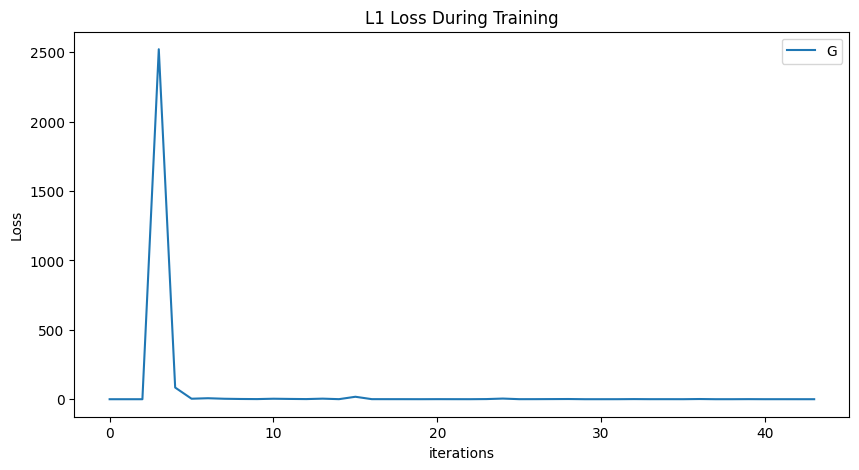

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,5))
plt.title("L1 Loss During Training")
plt.plot(G_losses,label="G")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

In [12]:
torch.save({
            'epoch': num_epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'model_seed_{}.pt'.format(torch.random.initial_seed()))

In [13]:
import cv2

# Load best model
checkpoint = torch.load('model_seed_{}.pt'.format(9706507364633013713))
# checkpoint = torch.load('model_seed_{}.pt'.format(torch.random.initial_seed()))
best_model = idist.auto_model(
    UNet(4)
)

best_model.load_state_dict(checkpoint['model_state_dict'])

root_dir = "dataset"
sony_test_csv_files = ["dataset/Sony_test_list.txt"]

sony_test_dataset = LabeledDataset(root_dir, *sony_test_csv_files, transform=transforms.Compose([
    transforms.ToTensor()
]))
sony_test_dataloader = DataLoader(sony_test_dataset, batch_size=1, num_workers=1)


tensor(9.9451e-05, device='cuda:0') tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0')
tensor(0.0249, device='cuda:0') tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(250., device='cuda:0')
0.4147461 0.0 0.0 1.0
0.4693966 0.0 0.0 1.0
0.5137516 0.891114 0.0 1.0
0.1745267 0.13415731 0.0 1.0
0.15320197 0.12263676 0.0 1.0
0.11769672 0.09105058 0.0 1.0


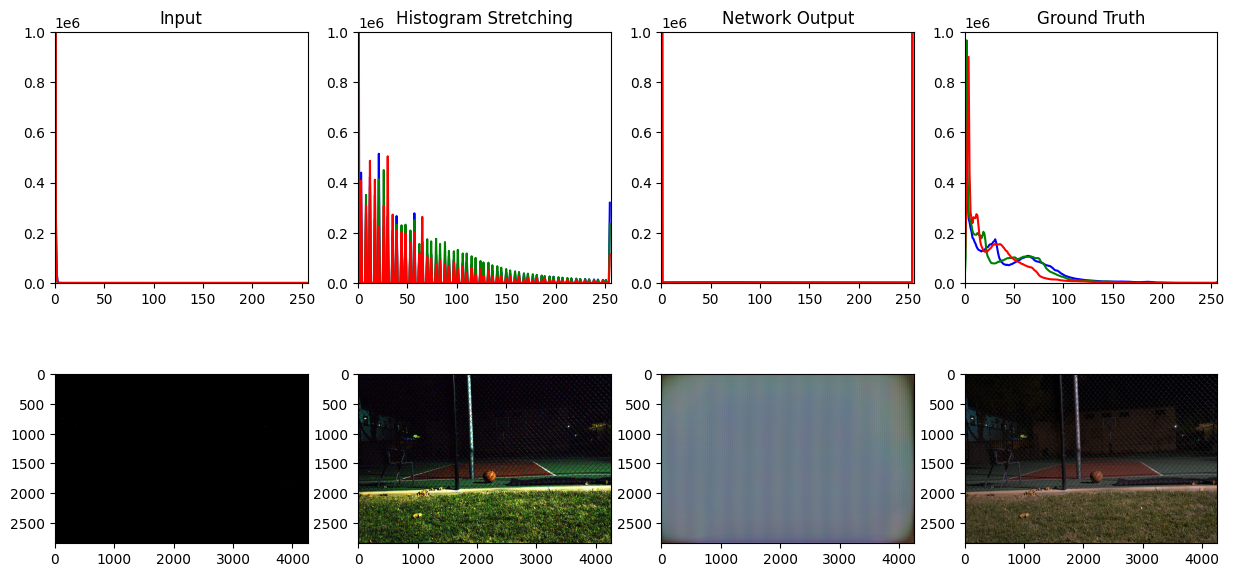

tensor(0.0003, device='cuda:0') tensor(0.0001, device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0')
tensor(0.0300, device='cuda:0') tensor(0.0126, device='cuda:0') tensor(0., device='cuda:0') tensor(100., device='cuda:0')
0.41362214 0.0 0.0 1.0
0.46948847 0.0 0.0 1.0
0.5179537 1.0 0.0 1.0
0.1745267 0.13415731 0.0 1.0
0.15320197 0.12263676 0.0 1.0
0.11769672 0.09105058 0.0 1.0


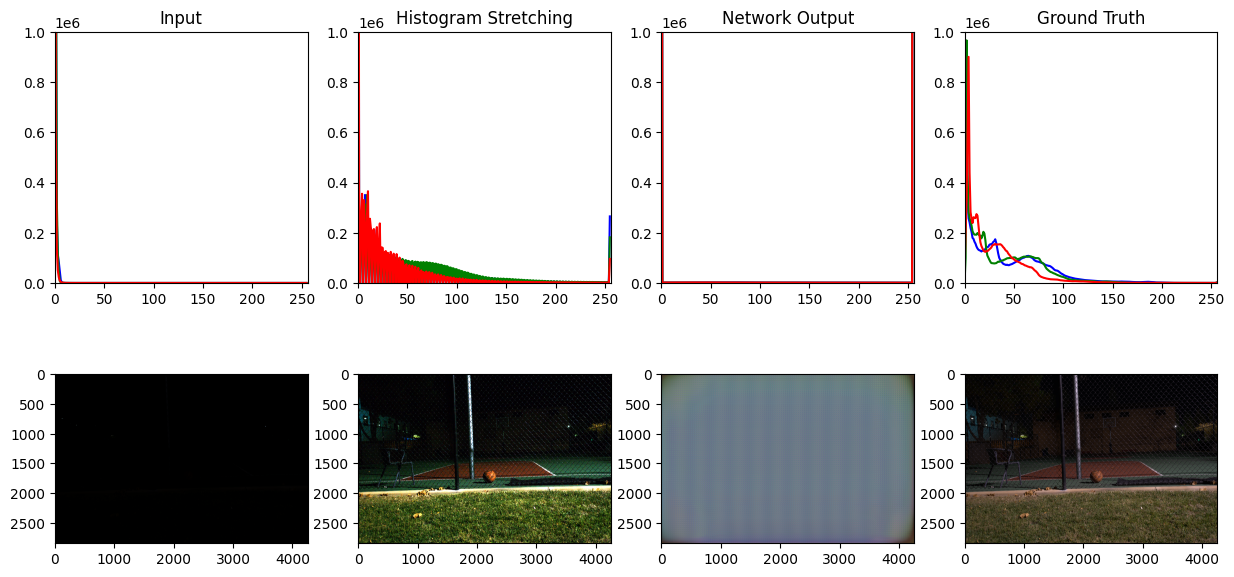

tensor(0.0001, device='cuda:0') tensor(6.3008e-05, device='cuda:0') tensor(0., device='cuda:0') tensor(0.0129, device='cuda:0')
tensor(0.0317, device='cuda:0') tensor(0.0158, device='cuda:0') tensor(0., device='cuda:0') tensor(3.2134, device='cuda:0')
0.4143297 0.0 0.0 1.0
0.4696473 0.0 0.0 1.0
0.5171727 1.0 0.0 1.0
0.16390072 0.16130312 0.0 1.0
0.13471788 0.12680247 0.0 1.0
0.13667648 0.1257496 0.0 1.0


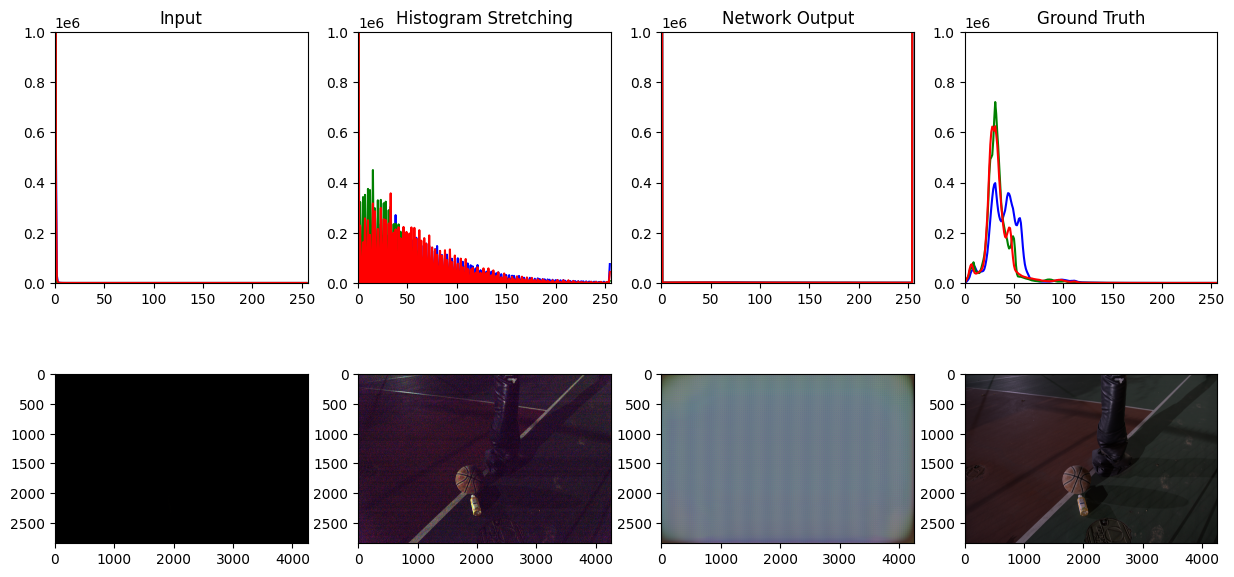

tensor(8.3668e-05, device='cuda:0') tensor(6.3008e-05, device='cuda:0') tensor(0., device='cuda:0') tensor(0.1387, device='cuda:0')
tensor(0.0209, device='cuda:0') tensor(0.0158, device='cuda:0') tensor(0., device='cuda:0') tensor(34.6702, device='cuda:0')
0.4137702 0.0 0.0 1.0
0.46964756 0.0 0.0 1.0
0.51832324 1.0 0.0 1.0
0.1526067 0.1371023 0.0 1.0
0.13751055 0.12762646 0.0 1.0
0.11115194 0.11282521 0.0 1.0


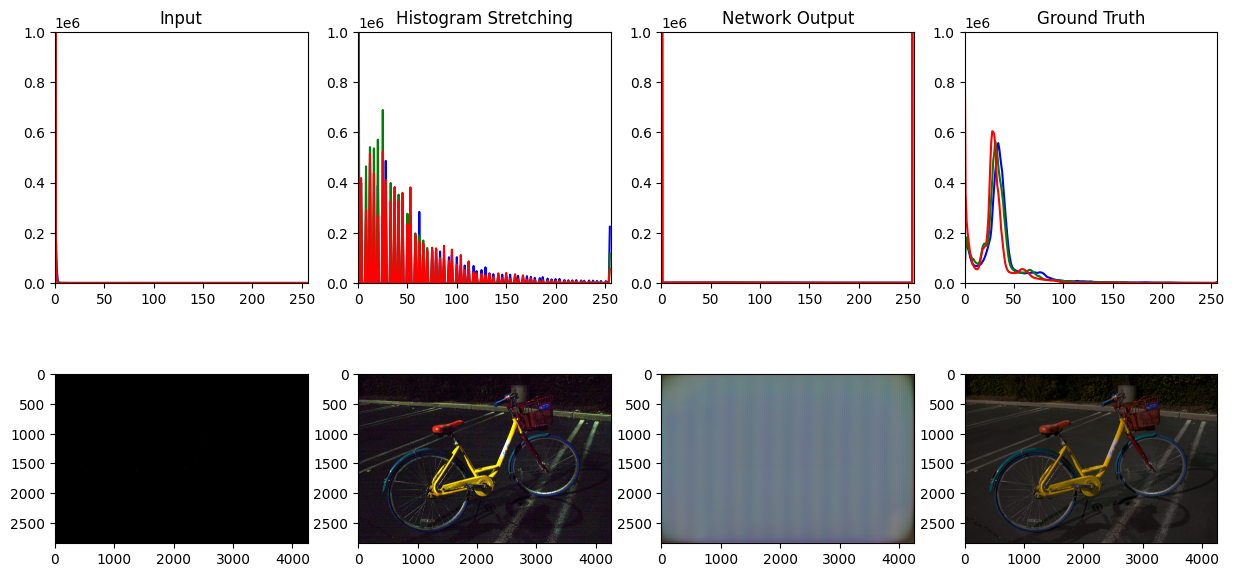

tensor(9.3496e-05, device='cuda:0') tensor(6.3008e-05, device='cuda:0') tensor(0., device='cuda:0') tensor(0.0594, device='cuda:0')
tensor(0.0234, device='cuda:0') tensor(0.0158, device='cuda:0') tensor(0., device='cuda:0') tensor(14.8384, device='cuda:0')
0.4138532 0.0 0.0 1.0
0.46956968 0.0 0.0 1.0
0.5180654 1.0 0.0 1.0
0.17585072 0.16221866 0.0 1.0
0.12842868 0.10785077 0.0 1.0
0.07044467 0.047241934 0.0 1.0


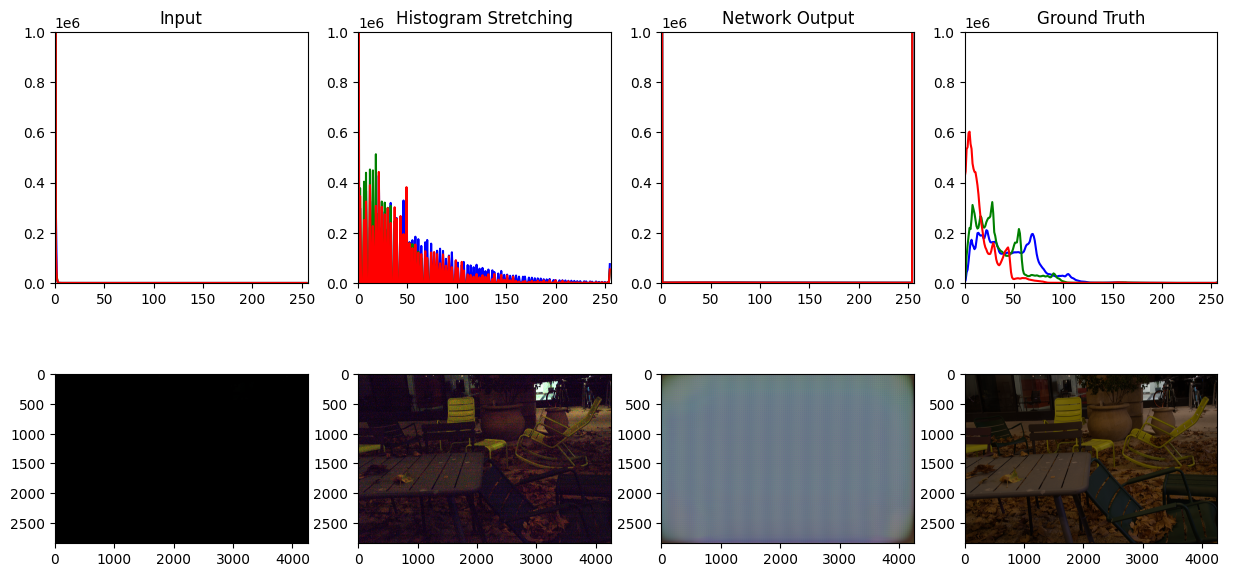

tensor(0.0002, device='cuda:0') tensor(0.0001, device='cuda:0') tensor(0., device='cuda:0') tensor(0.1466, device='cuda:0')
tensor(0.0224, device='cuda:0') tensor(0.0126, device='cuda:0') tensor(0., device='cuda:0') tensor(14.6620, device='cuda:0')
0.41369382 0.0 0.0 1.0
0.46955976 0.0 0.0 1.0
0.5188415 1.0 0.0 1.0
0.17585072 0.16221866 0.0 1.0
0.12842868 0.10785077 0.0 1.0
0.07044467 0.047241934 0.0 1.0


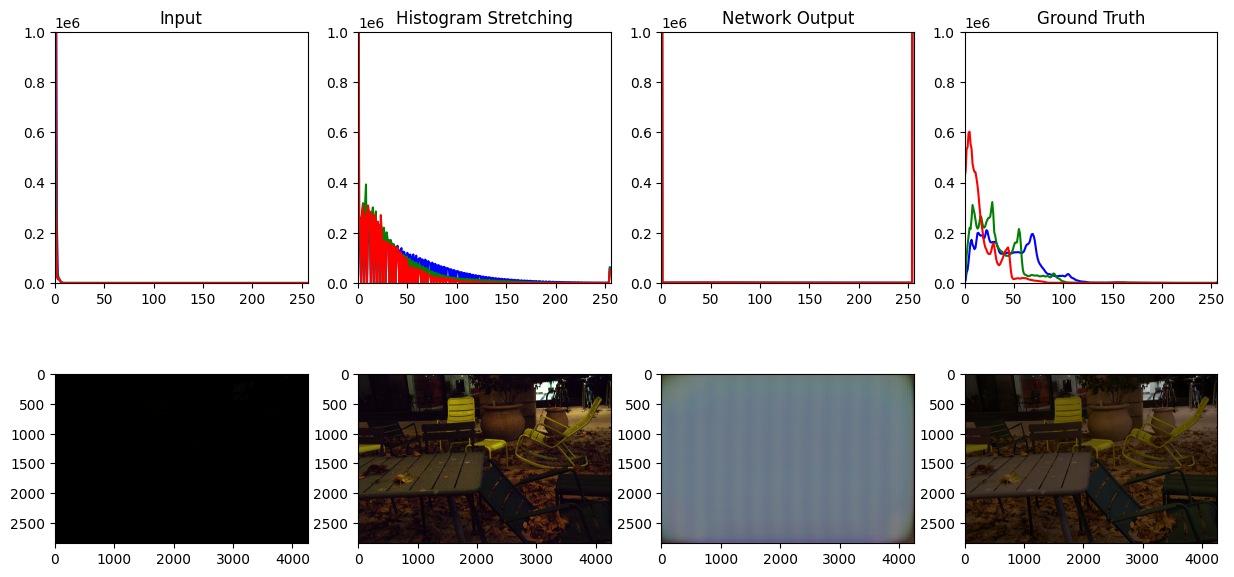

tensor(0.0011, device='cuda:0') tensor(0.0008, device='cuda:0') tensor(0., device='cuda:0') tensor(0.7309, device='cuda:0')
tensor(0.1149, device='cuda:0') tensor(0.0756, device='cuda:0') tensor(0., device='cuda:0') tensor(73.0893, device='cuda:0')
0.41432816 0.0 0.0 1.0
0.46978265 0.0 0.0 1.0
0.518652 1.0 0.0 1.0
0.45840585 0.45607692 0.0 1.0
0.36945933 0.37097734 0.004806592 1.0
0.22926527 0.18481727 0.0 1.0


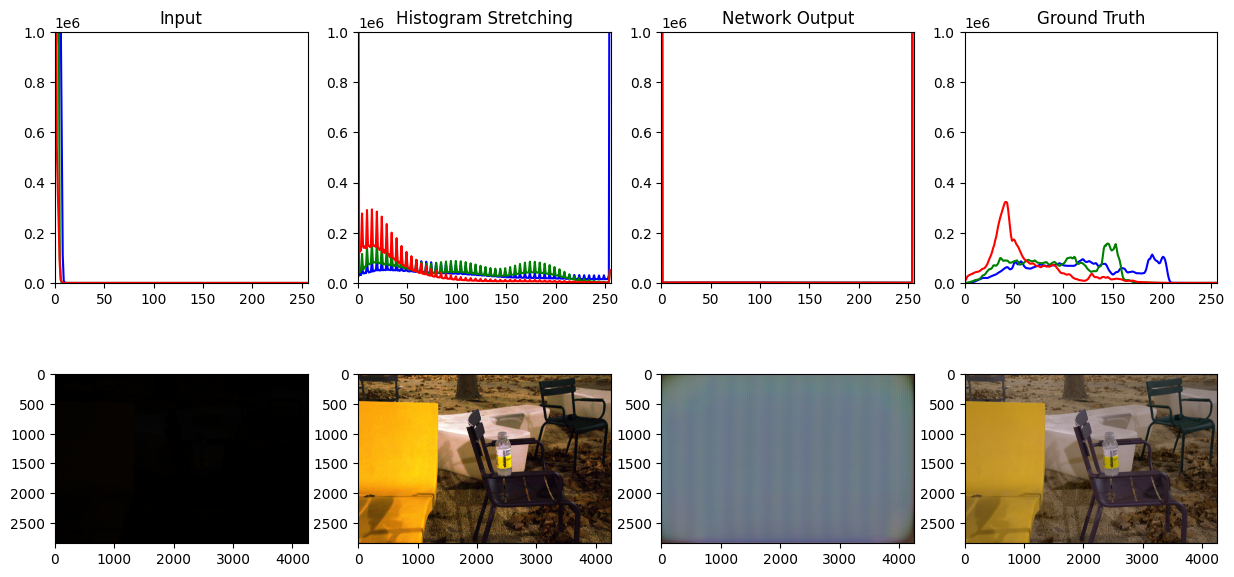

In [14]:
import matplotlib.pyplot as plt

with torch.no_grad():
    best_model.eval()
    list_samp = [1, 13, 27, 39, 51, 61, 73]
    o = 0
    for batch in sony_test_dataloader:
    # batch = next(iter(sony_test_dataloader))
        short, long, ratio, cam_model, exposure_ratio, _, _, short_raw = batch
        o += 1
        if o > list_samp[-1]:
            break
        if o not in list_samp:
            continue
        short_ = short
        short = short.to(idist.device())
        long = long.to(idist.device())

        short = pack_sony_raw(short)
        print(torch.mean(short), torch.median(short), torch.min(short), torch.max(short))
        long = long / 65535.0
        short = short * exposure_ratio.float().to(idist.device()).view(-1, 1, 1, 1)
        print(torch.mean(short), torch.median(short), torch.min(short), torch.max(short))
        
        
        output = best_model(short)
        # output = torch.nn.functional.pixel_shuffle(output, 2)

        output = output[0, :, :, :].to('cpu').numpy()
        output = np.minimum(np.maximum(output, 0), 1)
        gt_full = long[0, :, :, :].to('cpu').numpy()
        raw_input = short_raw[0, :, :, :].to('cpu').numpy() / 65535.0
        scale_full = np.float32(short_raw[0, :, :, :].to('cpu').numpy() / 65535.0)
        scale_full = scale_full * np.mean(gt_full) / np.mean(scale_full) 

        print(np.mean(output[0]), np.median(output[0]), np.min(output[0]), np.max(output[0]))
        print(np.mean(output[1]), np.median(output[1]), np.min(output[1]), np.max(output[1]))
        print(np.mean(output[2]), np.median(output[2]), np.min(output[2]), np.max(output[2]))
        print(np.mean(gt_full[0]), np.median(gt_full[0]), np.min(gt_full[0]), np.max(gt_full[0]))
        print(np.mean(gt_full[1]), np.median(gt_full[1]), np.min(gt_full[1]), np.max(gt_full[1]))
        print(np.mean(gt_full[2]), np.median(gt_full[2]), np.min(gt_full[2]), np.max(gt_full[2]))

        output = np.minimum(np.transpose(output, (1,2,0)) * 255, 255).astype(np.uint8)
        # output = (output-np.min(output))/(np.max(output)-np.min(output))
        gt_full = np.minimum(np.transpose(gt_full, (1,2,0)) * 255, 255).astype(np.uint8)
        raw_input = np.minimum(raw_input * 255, 255).astype(np.uint8)
        scale_full = np.minimum(scale_full * 255, 255).astype(np.uint8)

        color = ('b','g','r')
        plt.figure(figsize=(15,15))
        ax = plt.subplot(4,4,1)
        ax.set_title("Input")
        ax.set_ylim([0, 1e6])
        for i,col in enumerate(color):
            histr = cv2.calcHist([raw_input],[i],None,[256],[0,256])
            plt.plot(histr,color = col)
            plt.xlim([0,256])
        plt.subplot(4,4,5)
        plt.imshow(raw_input)

        ax = plt.subplot(4,4,2)
        ax.set_title("Histogram Stretching")
        ax.set_ylim([0, 1e6])
        for i,col in enumerate(color):
            histr = cv2.calcHist([scale_full],[i],None,[256],[0,256])
            plt.plot(histr,color = col)
            plt.xlim([0,256])
        plt.subplot(4,4,6)
        plt.imshow(scale_full)

        ax = plt.subplot(4,4,3)
        ax.set_title("Network Output")
        ax.set_ylim([0, 1e6])
        for i,col in enumerate(color):
            histr = cv2.calcHist([output],[i],None,[256],[0,256])
            plt.plot(histr,color = col)
            plt.xlim([0,256])
        plt.subplot(4,4,7)
        plt.imshow(output)

        ax = plt.subplot(4,4,4)
        ax.set_title("Ground Truth")
        ax.set_ylim([0, 1e6])
        for i,col in enumerate(color):
            histr = cv2.calcHist([gt_full],[i],None,[256],[0,256])
            plt.plot(histr,color = col)
            plt.xlim([0,256])
        plt.subplot(4,4,8)
        plt.imshow(gt_full)
        plt.show()

In [15]:
from ignite.metrics import PSNR, SSIM

def eval_step(engine, batch):
    short, long, ratio, cam_model, exposure_ratio, _, _, short_raw = batch

    short = short.to(idist.device())
    long = long.to(idist.device())

    short = pack_sony_raw(short)
    long = long / 65535.0
    short = short * exposure_ratio.float().to(idist.device()).view(-1, 1, 1, 1)   
    
    output = best_model(short)
    output = torch.minimum(torch.maximum(output, torch.Tensor([0]).to(idist.device())), torch.Tensor([1]).to(idist.device()))

    return output, long

evaluator = Engine(eval_step)
psnr = PSNR(data_range=1.0)
psnr.attach(evaluator, 'psnr')
ssim = SSIM(data_range=1.0)
ssim.attach(evaluator, 'ssim')
ProgressBar().attach(evaluator)

In [ ]:
root_dir = "dataset"
sony_val_csv_files = ["dataset/Sony_test_list.txt"]

sony_val_dataset = LabeledDataset(root_dir, *sony_val_csv_files, training=False, transform=transforms.Compose([
    transforms.ToTensor()
]))
sony_val_dataloader = idist.auto_dataloader(sony_val_dataset, batch_size=2, num_workers=8)

2023-06-13 02:49:27,063 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<utils.datasets.Labe': 
	{'batch_size': 2, 'num_workers': 8, 'pin_memory': True}


In [ ]:
state = evaluator.run(sony_val_dataloader)

Current run is terminating due to exception: CUDA out of memory. Tried to allocate 740.00 MiB (GPU 0; 23.69 GiB total capacity; 20.92 GiB already allocated; 654.06 MiB free; 21.68 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Engine run is terminating due to exception: CUDA out of memory. Tried to allocate 740.00 MiB (GPU 0; 23.69 GiB total capacity; 20.92 GiB already allocated; 654.06 MiB free; 21.68 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


OutOfMemoryError: CUDA out of memory. Tried to allocate 740.00 MiB (GPU 0; 23.69 GiB total capacity; 20.92 GiB already allocated; 654.06 MiB free; 21.68 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
print(state.metrics['psnr'])
print(state.metrics['ssim'])